# Lab Assignment One: Exploring Table Data

### Authors
- Juliana Antonio
- Xiaona Hang
- Chuanqi Deng


### 1. Business Understanding 

This data was collected through Bing images of various car types and uploaded on Kaggle. There are 4,165 images and 7 classes of cars, and all of them are larger than the 20 x 20 pixel size requirement. It is sepearated into two folders: testing and training; with subfolders for each car category. Although there is no information on why the dataset was collected, it is likely for training and evaluating machine learning models for image classification tasks related to automobiles.

Classifying vehicles is of great important in multiple facets of industry, the main one being transport and logistic management companies/systems (also known as Intelligent Transport System, or ITS), for traffic accident investigation, traffic flow monitoring, and autonomous driving, as indicated by this recent review (https://www.mdpi.com/1424-8220/23/10/4832). Typically the method that is use for predicting the features/type of car from an image is through deep learning, such as the convolutional neural networt (CNNs) for vehicle classification, and have seen some success with low-resolution images (https://www.mdpi.com/1424-8220/22/13/4740). Before one can use such highly sophiscated methods, it is imperative to prepare the data and reduce the dimensionality of the data through feature extraction. In this way, we can improve the efficiency of the classification and reduce the computational resources required for the predictive task. 

Some real life applications, as mentioned briefly with the ITS, we can utilze the prediction task to identify the automobile type, and then using information about the types of vehicles present in different areas, traffic management authorities can make informed decisions about traffic flow optimization, lane management, and infrastructure planning. 

### Measures of Success

In the application of traffic planning/monitoring with classifying a variety of automobiles on the road, there are a few ways to measure the success of the predictive model. Prediction and accuracy are fundamental, for the traffic managment system to rely on the prediction to make informed decisions on traffic flow optimization. Another important factor for success is having the classification in real-time, with no delay or latency. However, an often missed factor that would be paramount in the success of the machine learning model would be robustness. 

For example, let us take a random numpy array, with a training set of 800 synthetic images and 200 testing images, 32 x 32 pixels with 3 color channels (RGB):

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess the dataset
# For demonstration, we'll generate synthetic data
X_train = np.random.rand(800, 32, 32, 3)
y_train = np.random.randint(0, 7, size=800)
X_test = np.random.rand(200, 32, 32, 3)
y_test = np.random.randint(0, 7, size=200)

Next, we can just arbitrarily create and train a convolutional neural network (CNN) model for image classification tasks, with a specific architecture comprising convolutional and fully connected layers, compiled with the Adam optimizer and evaluated using sparse categorical cross-entropy loss and accuracy metrics.

In [ ]:
# Define a function to train the classification model
def train_model(X_train, y_train):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(7, activation='softmax')  # Assuming 7 output classes
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)  

    return model

Now, we will define a function 'evaluate_robustness' to assess the robustness of a trained classification model. Specifically, it tests the model's robustness using data augmentation, where the test data is augmented with variations in rotation, width, height, and zoom, and evaluates the model's accuracy on the augmented test data.

In [ ]:
# Define a function to perform robustness testing
def evaluate_robustness(model, X_test, y_test):
    # Evaluate accuracy on original test data
    accuracy_original = model.evaluate(X_test, y_test, verbose=0)[1]
    print("Accuracy on original test data:", accuracy_original)

    # Data augmentation for robustness testing
    datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
    augmented_iterator = datagen.flow(X_test, y_test, shuffle=False)
    X_augmented, y_augmented = augmented_iterator.next()

    accuracy_augmented = model.evaluate(X_augmented, y_augmented, verbose=0)[1]
    print("Accuracy on augmented test data:", accuracy_augmented)

    # Adversarial attack for robustness testing
    epsilon = 0.1  # Perturbation strength
    X_adversarial = X_test + epsilon * np.sign(np.random.randn(*X_test.shape))
    X_adversarial = np.clip(X_adversarial, 0, 1) 

    # Evaluate accuracy on adversarial test data
    accuracy_adversarial = model.evaluate(X_adversarial, y_test, verbose=0)[1]
    print("Accuracy on adversarial test data:", accuracy_adversarial)

model = train_model(X_train, y_train)

# Evaluate robustness
evaluate_robustness(model, X_test, y_test)

In this randomly generated data, we can see that these accuracies provide insights into how the model generalizes and performs under various conditions. In this case, the model's performance is relatively low across all datasets, indicating potential issues with generalization and robustness. Further analysis and improvements may be necessary to enhance the model's performance and robustness.

Dataset source: https://www.kaggle.com/datasets/kshitij192/cars-image-dataset

### 2. Data Preparation
#### 2.1. Read Images

In [1]:
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.decomposition import PCA
from skimage import metrics
from sklearn.preprocessing import LabelEncoder, minmax_scale

In [2]:
images = defaultdict(list)
labels = defaultdict(list)
uniformed_size = (224,224)

# load and resize images
for image_path in Path('data').rglob('*.jpg'):
    class_name = image_path.parent.stem
    train_test = image_path.parent.parent.stem
    img = cv2.resize(cv2.imread(str(image_path)),uniformed_size)
    images[train_test].append(img)
    labels[train_test].append(class_name)

# concatenate to two ndarrays
train_imgs = np.concatenate([images['train']])
test_imgs = np.concatenate([images['test']])

# encode string lables to numeric labels
encoder = LabelEncoder()
encoder.fit(labels['test'])
test_labels = encoder.transform(labels['test'])
train_labels = encoder.transform(labels['train'])

print(f"Train: {train_imgs.shape}, Test: {test_imgs.shape}")

Train: (3352, 224, 224, 3), Test: (813, 224, 224, 3)


#### 2.2. Linearize

In [3]:
train_imgs = train_imgs.reshape((len(train_imgs), -1))
test_imgs = test_imgs.reshape((len(test_imgs), -1))
print(f"Train: {train_imgs.shape}, Test: {test_imgs.shape}")

Train: (3352, 150528), Test: (813, 150528)


#### 2.3. Visualization

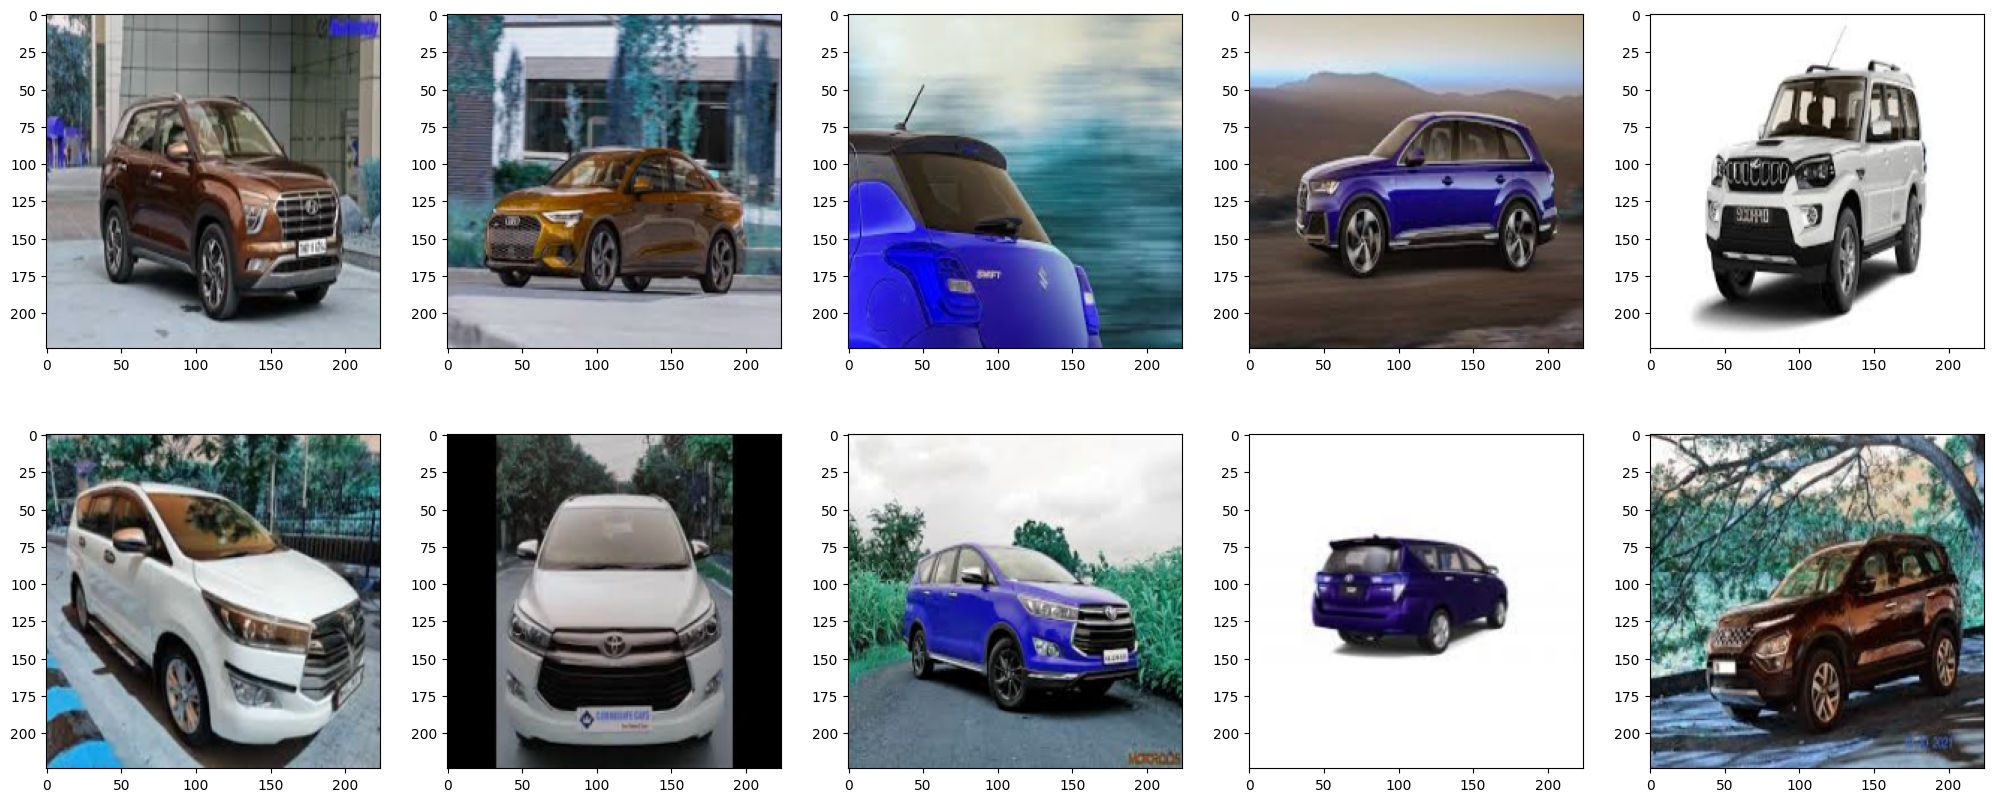

In [4]:
plt.figure(figsize=(25,10))
for i, r_idx in enumerate(np.random.randint(0, len(images['train']), 10)):
    ax = plt.subplot(2,5,i+1)
    ax.imshow(images['train'][r_idx])

### 3. Data Reduction

#### 3.1 PCA

In [5]:
def run_PCA_analysis(data, n_components=150, required_component_ratio = 0.8, randomized = False):
    # PCA
    pca = PCA(n_components, svd_solver="randomized" if randomized else "auto")
    pca_data = pca.fit_transform(data)
    
    # Analyze how many components are required to adequately represent the image data.
    accumulated_ratio = np.cumsum(pca.explained_variance_ratio_)
    ratio_idx = np.argmax(accumulated_ratio >= required_component_ratio)

    # ploting
    plt.figure(figsize=(20,5))
    plt.bar(range(1, n_components+1), pca.explained_variance_ratio_)
    plt.xticks(range(1, n_components+1, 3), rotation=70)
    plt.yticks(np.arange(0, 0.30, 0.01), [f"{x*100:.1f}%" for x in np.arange(0, 0.30, 0.01)])
    plt.xlim(0, n_components+1)

    ax = plt.twinx()
    ax.set_yticks(np.arange(0, 1.01, 0.05), [f"{x*100:.1f}%" for x in np.arange(0, 1.01, 0.05)])
    ax.set_ylim(0,1)
    ax.plot(range(1, n_components+1), accumulated_ratio, color='orange')
    ax.axvline(x=ratio_idx, color='red', linestyle='--')
    ax.axhline(y=required_component_ratio, color='red', linestyle='--')

    plt.title("explained variance of each components")
    return pca, pca_data

CPU times: total: 1min
Wall time: 9.75 s


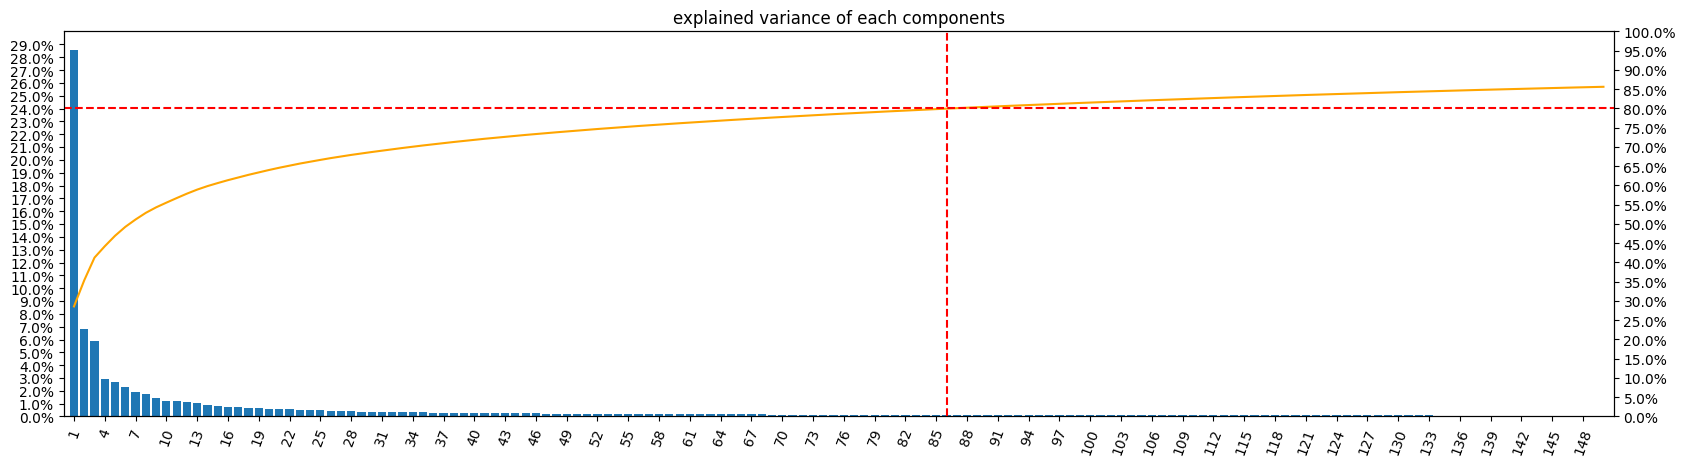

In [27]:
n_components = 150
required_component_ratio = 0.8
original_images = test_imgs
%time pca, pca_data = run_PCA_analysis(original_images, n_components, required_component_ratio);

The analysis above used PCA to deduct the image demension from 150528 to 150. And then the number of components that are required to adequately represent the image data is determined by a 0.8 threshold. As the red dotted lines shown above, it is clear that the first 112 principal components can adequately represent the images with given threshold.

#### 3.2 Random PCA

CPU times: total: 56 s
Wall time: 9.75 s


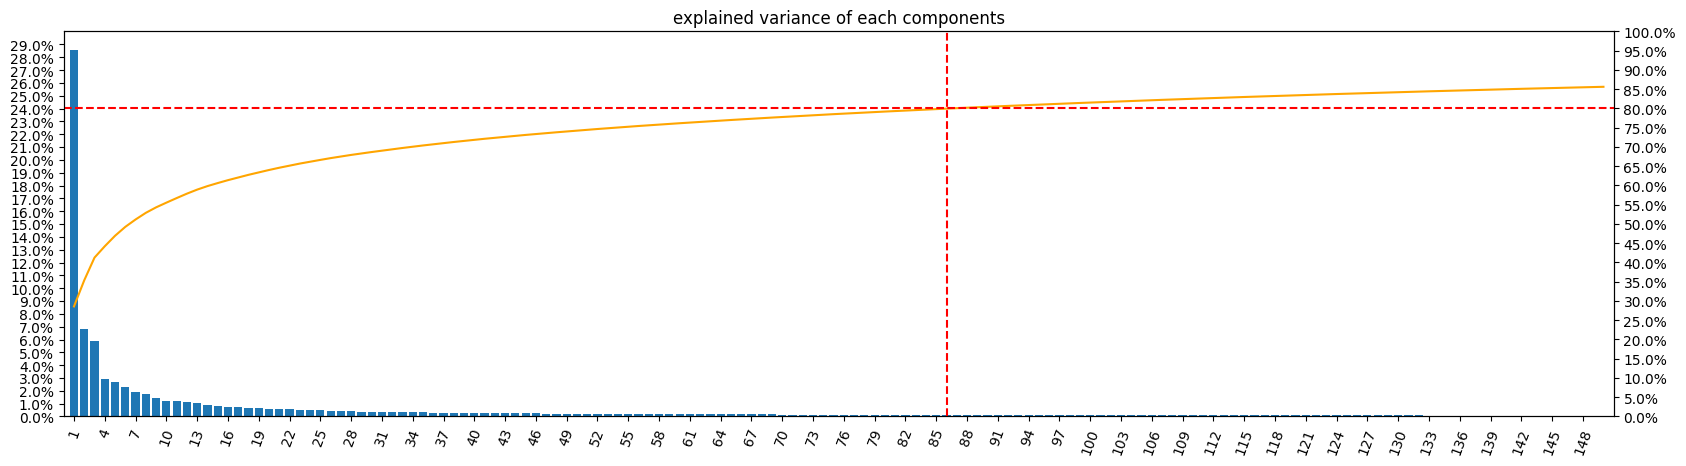

In [14]:
%time random_pca, random_pca_data = run_PCA_analysis(original_images, n_components, required_component_ratio, randomized = True);

The randomized PCA produced similar result to PCA. The number of components that are required to adequately represent the image data is 112.

#### 3.3 Comparison between PCA and Randomized PCA

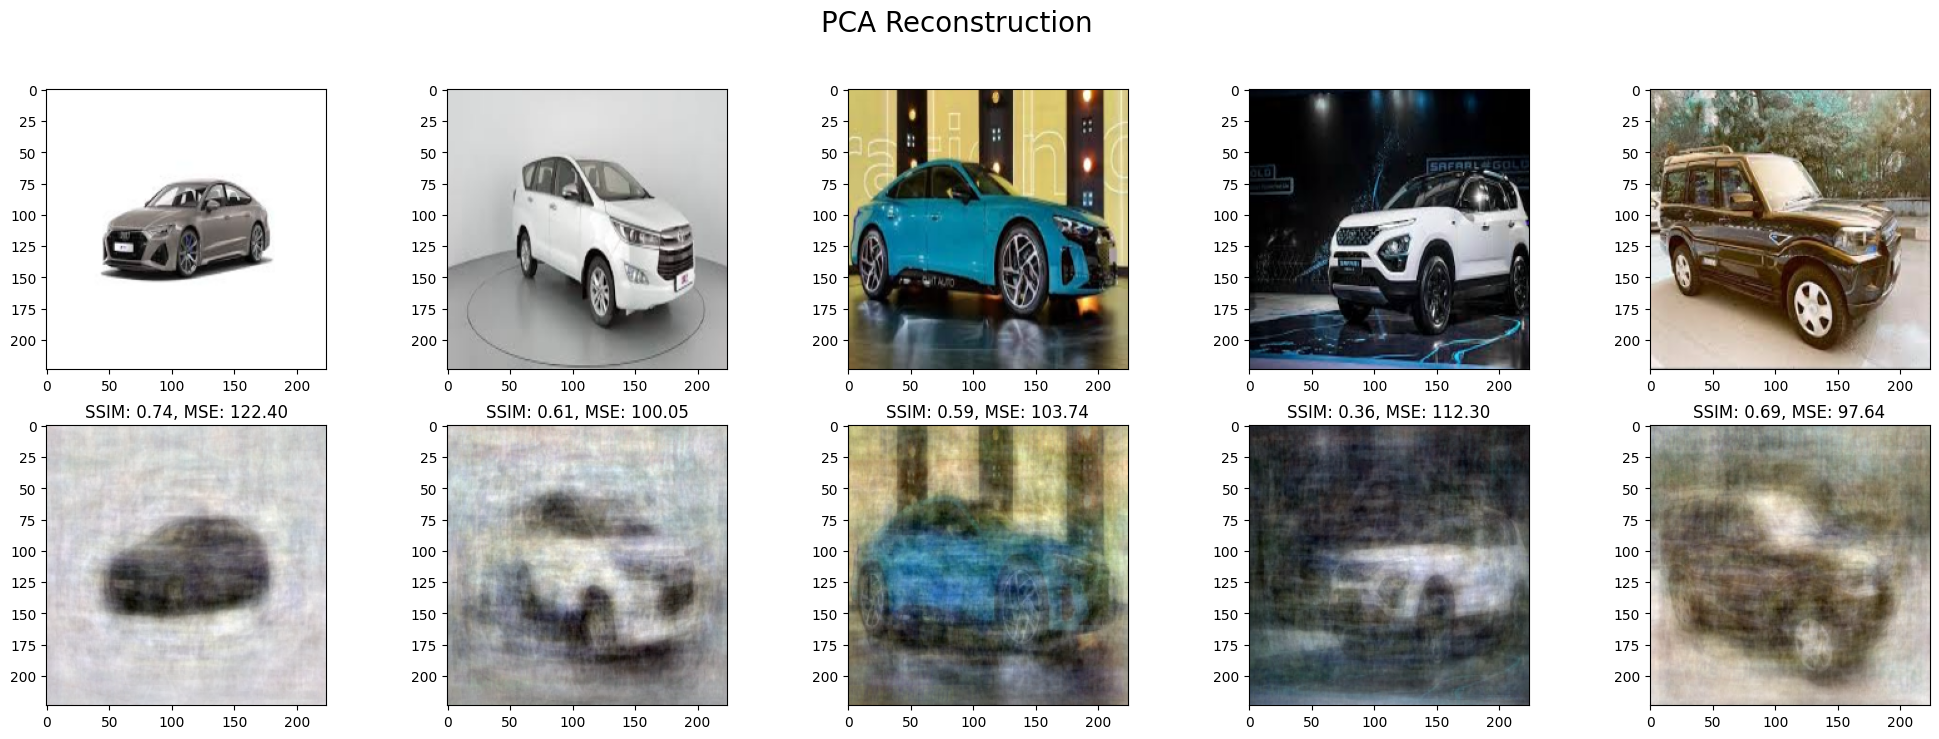

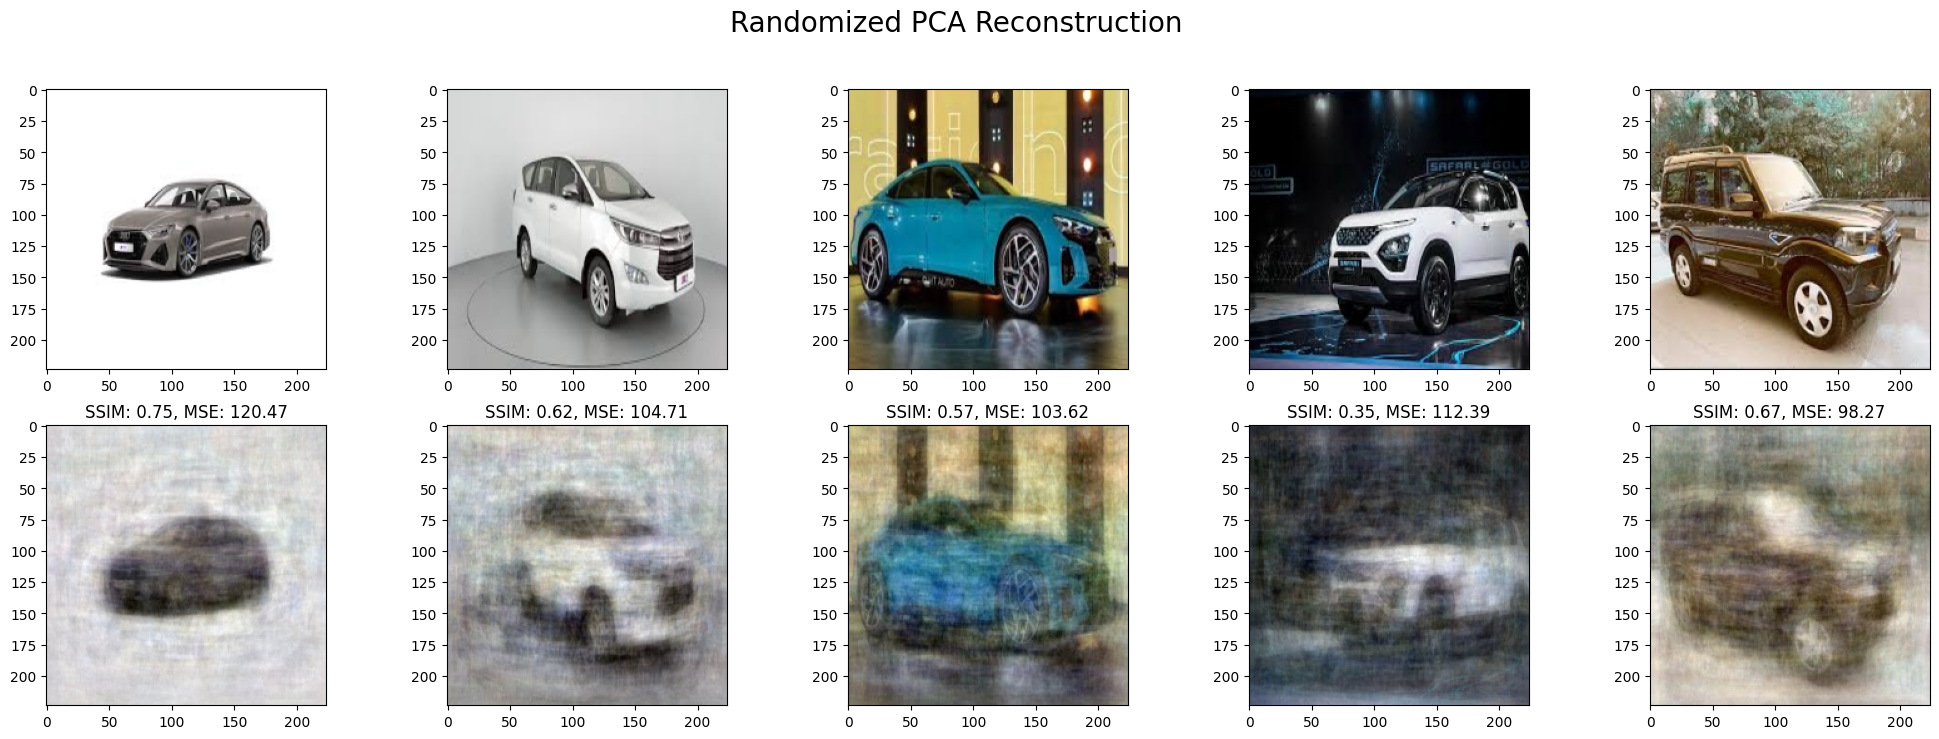

In [28]:
def reconstruct_image(trans_obj, low_rep):
    # reconstruct images from deducted data
    rec_image = trans_obj.inverse_transform(low_rep)
    shp = rec_image.shape
    rec_image = minmax_scale(rec_image.ravel(), (0,255)).astype(np.uint8)
    return rec_image.reshape(shp)

def reconstruct(randomized_PCA=False):
    # reconstruct few images and visualize
    plt.figure(figsize=(25,8))
    for i, r_idx in enumerate(np.random.randint(0, len(original_images), 5)):
        ax = plt.subplot(2,5,i+1)
        ax.imshow(original_images[r_idx].reshape((*uniformed_size, -1)))
        low_rep = random_pca_data[r_idx:r_idx+1] if randomized_PCA else pca_data[r_idx:r_idx+1]
        rec_image = reconstruct_image(random_pca if randomized_PCA else pca, low_rep)
        ax = plt.subplot(2,5,i+6)
        ax.imshow(rec_image.reshape((*uniformed_size, -1)))
        
        # calculate MSE and SSIM
        SSIM = metrics.structural_similarity(original_images[r_idx], rec_image.ravel())
        MSE = np.mean((original_images[r_idx] - rec_image) ** 2)
        ax.set_title(f"SSIM: {SSIM:.2f}, MSE: {MSE:.2f}")

    plt.suptitle(('Randomized ' if randomized_PCA else '') +'PCA Reconstruction', fontsize = 20)

# make sure the comparison use same set of images
seed = np.random.randint(0, 9999) 
np.random.seed(seed)

reconstruct(randomized_PCA = False)
np.random.seed(seed)
reconstruct(randomized_PCA = True)

In [36]:
def calc_metrics(rec_images):
    # calculate SSIM and MSE metrics
    SSIMs, MSEs = [], []
    for i in range(original_images.shape[0]):
        MSE = np.mean((original_images[i] - rec_images[i]) ** 2)
        MSEs.append(MSE)
        SSIM = metrics.structural_similarity(original_images[i], rec_images[i])
        SSIMs.append(SSIM)
    return SSIMs, MSEs

# reconstruct all images
rec_images = reconstruct_image(pca, pca_data)
rec_images_random = reconstruct_image(random_pca, random_pca_data)

# calculate SSIM and MSE
SSIMs_pca, MSEs_pca = calc_metrics(rec_images)
SSIMs_random_pca, MSEs_random_pca = calc_metrics(rec_images_random)

Text(0.5, 0, 'MSE')

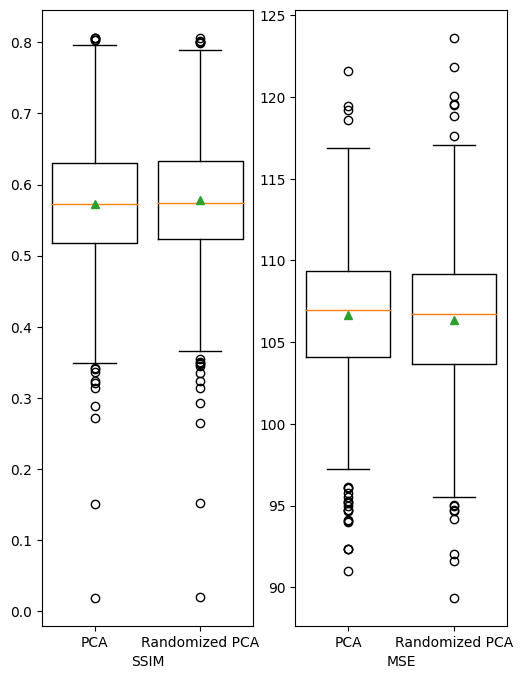

In [67]:
# Visualize SSIM and MSE
plt.figure(figsize=(6,8))
ax = plt.subplot(1,2,1)
ax.boxplot([SSIMs_pca,SSIMs_random_pca], showmeans=True, widths = 0.8)
ax.set_xticklabels(['PCA', 'Randomized PCA'])
ax.set_xlabel('SSIM')
#ax.axhline(np.mean(SSIMs_pca))
ax = plt.subplot(1,2,2)
ax.boxplot([MSEs_pca, MSEs_random_pca], showmeans=True, widths = 0.8)
#ax.axhline(np.mean(MSEs_pca))
ax.set_xticklabels(['PCA', 'Randomized PCA'])
ax.set_xlabel('MSE')

From the analysis above, the Randomized PCA have a slightly better average representation (green triangles) compared to PCA. The Randomized PCA presents a higher similarity on reconstructed images and lower MSE than PCA. Therefore, Randomized PCA is better at representing the images with fewer components. I prefer Randomized PCA. It is more efficient on large datasets.

References:

- Kaggle. Stroke Prediction Dataset. https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download (Accessed 2-04-2024)

- Center for Disease Control and Prevention. Stroke Facts. https://www.cdc.gov/stroke/facts.htm (Accessed 02-05-2024)

- Stroke Awareness Foundation. Stroke Risk Factors. https://www.strokeinfo.org/stroke-risk-factors/ (Accessed 02-05-2024)

- M.S. Pathan, et. al. "Identifying Stroke Indicators Using Rough Sets". https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9264165 (Accessed 02-05-2024)

- E.M. Alanazi, et. al. "Predicting Risk of Stroke From Lab Tests Using Machine Learning Algorithms: Development and Evaluation of Prediction Models" https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8686476/ (Accessed 02-05-2024)

- D. Zaric. Better Heatmaps and Correlation Matrix Plots in Python. https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec#:~:text=Let's%20start%20by%20making%20a,the%20larger%20the%20correlation%20magnitude. (Accessed 02-07-2024) 



